[ Source : https://www.youtube.com/watch?v=_BdBJOOqMes&list=PLtGXgNsNHqPTgP9wyR8pmy2EuM2ZGHU5Z&index=1 ]

#### PREPARATION

In [1]:
# Connect to drive to retrieve data 
# (you might need to copy the DATA folder onto your Google Drive manually)
from google.colab import drive
drive.mount('/content/drive');

Mounted at /content/drive


In [2]:
# (Installation)
!pip install mne;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.7 MB/s eta 0:00:00


In [3]:
# Imports
from glob import glob

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os, mne

import tensorflow_datasets as tfds
from tensorflow.keras.constraints import max_norm

In [4]:
# Activate GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [5]:
# Navigate to project directory 
%cd drive/MyDrive/Github/IANNWTF_hw/Final
%ls

/content/drive/MyDrive/Github/IANNWTF_hw/Final
checkpoint  EEGNet.ipynb  trained_eegnet_RUN1.data-00000-of-00001
DATA/       logs/         trained_eegnet_RUN1.index


### DATA 

Data Summary:

This dataset contains electroencephalographic (EEG) recordings of 25 healthy participants who tested the Brain Invaders, a visual P300 Brain-Computer Interface inspired by the classic video game Space Invaders. The visual P300 is an event-related potential elicited by a visual stimulation, peaking 240-600 ms after stimulus onset. The EEG data were recorded using 16 electrodes in an experiment conducted at the GIPSA-lab in Grenoble, France in 2012 (Van Veen, 2013 and Congedo, 2013). The experiment description is available at [https://hal.archives-ouvertes.fr/hal-02126068 ]. Python code for manipulating the data is available at [https://github.com/plcrodrigues/py.BI.EEG.2012-GIPSA ]. The ID of this dataset is BI.EEG.2012-GIPSA.

The BCI Competition IV dataset 2a is a publicly available dataset of EEG recordings from healthy participants. EEG is a non-invasive method of measuring the electrical activity of the brain.

#### Load all data samples from Google Drive

In [6]:
%ls 
all_file_path = glob('DATA/**/**/*.csv', recursive=True)
print(len(all_file_path), all_file_path[0])
training_file_path = [p for p in all_file_path if "training.csv" in p.split("/")]
print(len(training_file_path), training_file_path[0])
online_file_path = [p for p in all_file_path if "online.csv" in p.split("/")]
print(len(online_file_path), online_file_path[0])

checkpoint  EEGNet.ipynb  trained_eegnet_RUN1.data-00000-of-00001
DATA/       logs/         trained_eegnet_RUN1.index
24 DATA/subject_04/subject_04/online.csv
12 DATA/subject_04/subject_04/training.csv
12 DATA/subject_04/subject_04/online.csv


In [7]:
# Parameters for reading EEG data
chnames = ['F7',
          'F3',
          'Fz',
          'F4',
          'F8',
          'T7',
          'C3',
          'Cz',
          'C4',
          'T8',
          'P7',
          'P3',
          'Pz',
          'P4',
          'P8',
          'O1',
          'O2',
          'STI 014']
chtypes = ['eeg'] * 17 + ['stim']  
info = mne.create_info(ch_names=chnames, sfreq=128,
                      ch_types=chtypes,
                      verbose=False)
info.set_montage(montage='standard_1020')

# Parameters for preprocessing
fmin = 1
fmax = 24

In [8]:
def read_data(file_path, info, fmin, fmax):
  raw_list = []
  epoch_list = []
  for path in file_path:
    # Reads original data
    print("-> Reads in : ", path)
    data = pd.read_csv(path).T
    print("-> original shape :", data.shape)

    # Selects columns (???)
    S = data.iloc[1:18,:]
    stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
    data = np.concatenate([S, stim])
    print("-> modified shape :", data.shape, '\n')

    # Creates mne.io.Raw object
    data = mne.io.RawArray(data, info, verbose=False)   # preload : data will be loaded into memory at object creation for fast access during training
    # ?
    data.set_eeg_reference()
    # ?
    data.filter(fmin, fmax)
    
    # ???
    events = mne.find_events(raw=data.copy(), shortest_event=1, verbose=False)
    event_id = {'NonTarget': 1, 'Target': 2}
    epochs = mne.Epochs(data, events, event_id, tmin=0.0, tmax=0.8, baseline=None, verbose=False, preload=True)
    epochs.pick_types(eeg=True)
    print("-> epochs data set shape :", epochs[0].get_data().shape)
  
    raw_list.append(data)
    epoch_list.append(epochs)
    print("-----------------------------------------------")
  return raw_list, epoch_list

raw_list, epoch_list = read_data(training_file_path, info, fmin, fmax);

-> Reads in :  DATA/subject_04/subject_04/training.csv
-> original shape : (20, 46995)
-> modified shape : (18, 46995) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_03/subject_03/training.csv
-> original shape : (20, 47275)
-> modified shape : (18, 47275) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.4s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_01/subject_01/training.csv
-> original shape : (20, 46803)
-> modified shape : (18, 46803) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_02/subject_02/training.csv
-> original shape : (20, 45811)
-> modified shape : (18, 45811) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_04/subject_04/training.csv
-> original shape : (20, 46995)
-> modified shape : (18, 46995) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.6s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_04/subject_04/training.csv
-> original shape : (20, 46995)
-> modified shape : (18, 46995) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.4s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_03/subject_03/training.csv
-> original shape : (20, 47275)
-> modified shape : (18, 47275) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.4s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_03/subject_03/training.csv
-> original shape : (20, 47275)
-> modified shape : (18, 47275) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.4s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_01/subject_01/training.csv
-> original shape : (20, 46803)
-> modified shape : (18, 46803) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_01/subject_01/training.csv
-> original shape : (20, 46803)
-> modified shape : (18, 46803) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_02/subject_02/training.csv
-> original shape : (20, 45811)
-> modified shape : (18, 45811) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------
-> Reads in :  DATA/subject_02/subject_02/training.csv
-> original shape : (20, 45811)
-> modified shape : (18, 45811) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)



<ipython-input-8-c8467b4c352d>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stim = (data.iloc[18,:] + data.iloc[19,:])[None,:]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished


-> epochs data set shape : (1, 17, 103)
-----------------------------------------------


#### Data Inspection

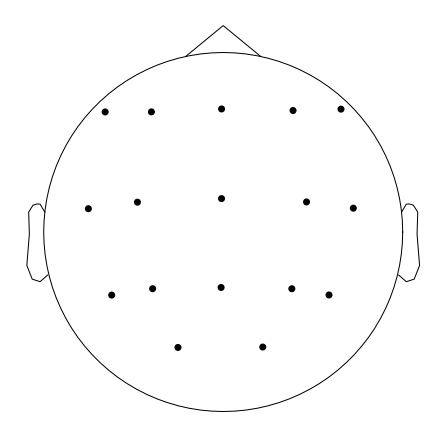

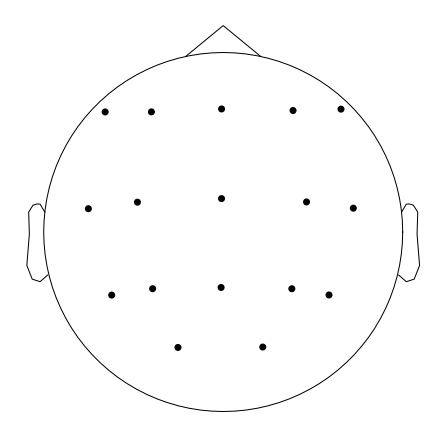

In [9]:
subj = 0

%matplotlib inline
# raw_list[0].plot_sensors(show=True)
# epoch_list[subj].info.set_montage('standard_1020')
epoch_list[subj].plot_sensors(show=True) # kind=topomap / 3d / select

(18, 46995)


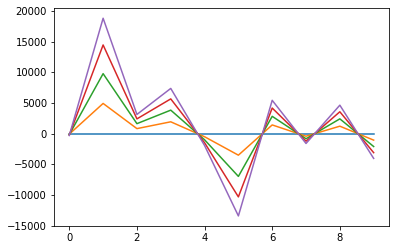

In [10]:
print(raw_list[subj].get_data().shape)
plt.plot(raw_list[subj].get_data()[:10,:5]);

In [11]:
print(raw_list[subj])

<RawArray | 18 x 46995 (367.1 s), ~6.5 MB, data loaded>


In [12]:
print(raw_list[subj])
raw_list[subj]

<RawArray | 18 x 46995 (367.1 s), ~6.5 MB, data loaded>


<RawArray | 18 x 46995 (367.1 s), ~6.5 MB, data loaded>

In [13]:
print(epoch_list[subj])
epoch_list[subj]

<Epochs |  765 events (all good), 0 - 0.796875 sec, baseline off, ~10.2 MB, data loaded,
 'NonTarget': 637
 'Target': 128>


Number of events,765
Events,NonTarget: 637Target: 128
Time range,0.000 – 0.797 sec
Baseline,off


Using matplotlib as 2D backend.


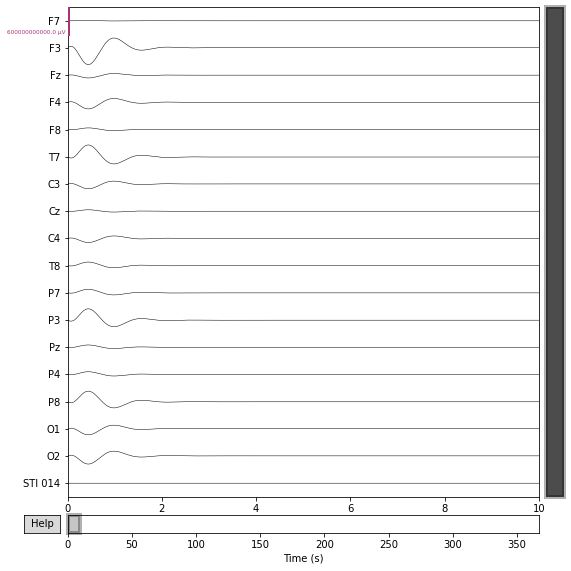

In [14]:
raw_list[subj].copy().plot(scalings=3e5); # Need to rescale from uV to V by 1e6, but thats weird... [Source : https://github.com/mne-tools/mne-python/issues/5539]

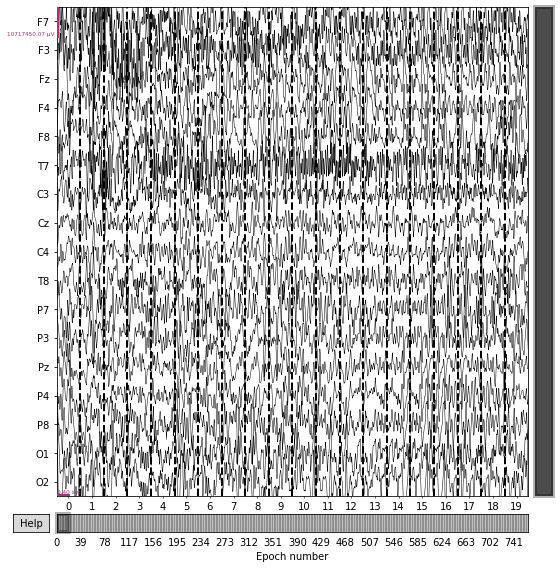

In [15]:
epoch_list[subj].copy().plot(scalings='auto');

Raw data and Training Epochs subject 0 || <class 'numpy.ndarray'>
----------------------------------------------------------------
[1] whole signal, channel  0 : (46995,)  || 3 % 
[2] one epoch, all channels  : (17, 103) || 20 % 
[3] one epoch, channel  0    : (103,)    || 20 %


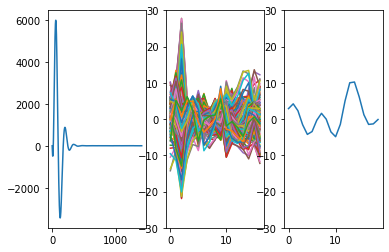

In [16]:
# Plotting interactively in more detail
chn = 0
e = 0
window_raw = 3
window_e = 20
window_e = 20

raw_data_matrix = raw_list[subj].get_data()[chn]
epochs_data_matrix = epoch_list[e].get_data()[chn] 
print("Raw data and Training Epochs subject", subj, "||", type(raw_data_matrix))
print("----------------------------------------------------------------")

print("[1] whole signal, channel ",chn,":",raw_data_matrix.shape," ||",window_raw,"%", 
      "\n[2] one epoch, all channels  :",epochs_data_matrix.shape,"||",window_e,"%", 
      "\n[3] one epoch, channel ",chn,"   :",epochs_data_matrix[chn, :].shape,"   ||",window_e,"%")

epochs_chn_1 = epochs_data_matrix[chn,:]  # Select specific channel

plt.subplot(1, 3, 1)
plt.plot(raw_data_matrix[:int(raw_data_matrix.shape[0]/100*window_raw)]) 
plt.subplot(1, 3, 2)
plt.plot(epochs_data_matrix[:int(epochs_data_matrix.shape[1]/100*window_e)]) 
plt.ylim([-30, 30])
plt.subplot(1, 3, 3)
plt.plot(epochs_chn_1[:int(epochs_data_matrix.shape[1]/100*window_e)])
plt.ylim([-30, 30])

plt.show()

[1] The amplitude of the EEG signal over time for the first channel.</br>
[2] The x-axis of the plot represents time, and the y-axis represents the amplitude of the EEG signal in microvolts. The shaded region around each line represents the standard error of the mean across epochs.</br>
[3] Similar to *\[2]* but only one channel selected

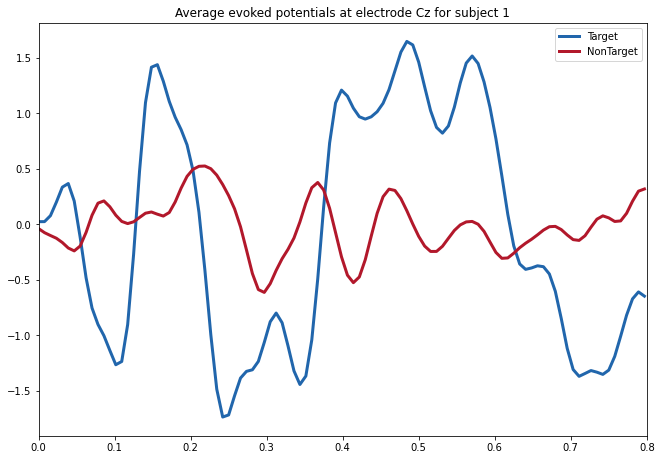

In [17]:
### from dataset paper...
raw_list[subj] 
chname2idx = {}
for i, chn in enumerate(raw_list[subj].ch_names):
  chname2idx[chn] = i

fig, ax = plt.subplots(facecolor='white', figsize=(10.9,  7.6))
evkTarget = epoch_list[subj]['Target'].average().data[chname2idx['Cz'],:]
evkNonTarget = epoch_list[subj]['NonTarget'].average().data[chname2idx['Cz'],:]
t = np.arange(len(evkTarget)) / epoch_list[subj].info['sfreq']
ax.plot(t, evkTarget, c='#2166ac', lw=3.0, label='Target')
ax.plot(t, evkNonTarget, c='#b2182b', lw=3.0, label='NonTarget')
ax.set_xlim(0, 0.8)
ax.set_title('Average evoked potentials at electrode Cz for subject ' + str(1))
ax.legend();

#### Indipendent component analysis (ICA)

In [18]:
ica = mne.preprocessing.ICA(n_components=17, random_state=0)

In [19]:
ica.fit(raw_list[subj].copy().filter(1,24))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 423 samples (3.305 sec)

Fitting ICA to data using 17 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished


Selecting by number: 17 components
Fitting ICA took 5.2s.


<ipython-input-19-dce87a27b40d>:1: RuntimeWarning: Using n_components=17 (resulting in n_components_=17) may lead to an unstable mixing matrix estimation because the ratio between the largest (17) and smallest (1e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 1
  ica.fit(raw_list[subj].copy().filter(1,24))


Method,fastica
Fit,40 iterations on raw data (46995 samples)
ICA components,17
Available PCA components,17
Channel types,eeg
ICA components marked for exclusion,—


In [20]:
print(chnames)

['F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'STI 014']


In [21]:
bad_idx, scores = ica.find_bads_eog(raw_list[subj],chnames[16],threshold=2)
print(bad_idx)

Using EOG channel: O2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

[16, 15, 11]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [22]:
ica.exclude = bad_idx

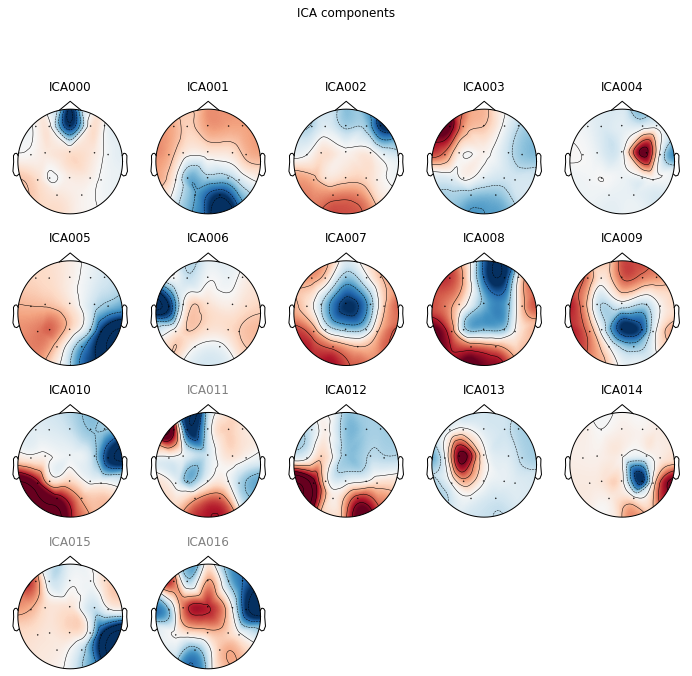

[<MNEFigure size 702x696.24 with 17 Axes>]

In [23]:
ica.plot_components()

Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 3 ICA components
    Projecting back using 17 PCA components


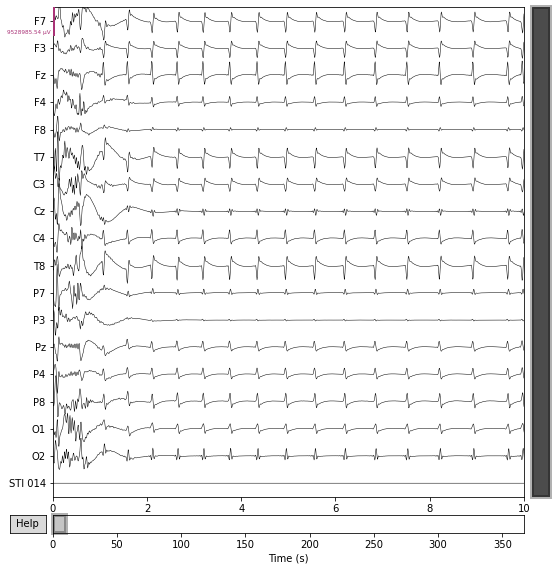

Applying ICA to Epochs instance
    Transforming to ICA space (17 components)
    Zeroing out 3 ICA components
    Projecting back using 17 PCA components


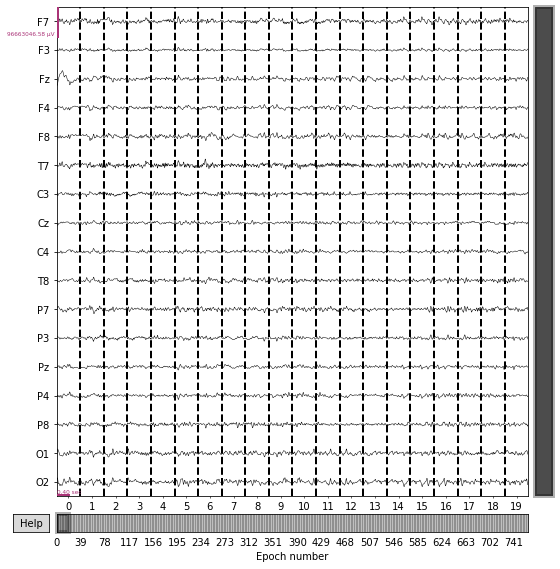

In [24]:
ica.apply(raw_list[subj].copy(), exclude=ica.exclude).plot(scalings='auto')
ica.apply(epoch_list[subj].copy(), exclude=ica.exclude).plot(scalings='auto');

#### Spectogram

In [25]:
# TODO : Function to view epoch samples (1 of each class) as spectogram (possibly before and after different filters...)


#### Preprocessing

In [27]:
# Hyperparameters :
batch_size = 16
# Set the number of kernels to 1
n_kernels = 1
n_classes = len(tf.unique(epoch_list[0].events[:,-1]))   ### TODO: May be wrong on diferent datatest...

n_epochs = 300
loss = 'categorical_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']

In [28]:
def get_class_weights(epochs) :
  labels = [str(label) for label in epochs.event_id.keys()]
  n = len(epochs)
  class_weights = {}

  for l in labels :
    class_weights[epoch_list[0].event_id[l]] = int(1/(len(epochs[l])/n))
  return class_weights

print(f'Events       : {epoch_list[0].event_id} \nClass weights: {get_class_weights(epoch_list[0])}')

Events       : {'NonTarget': 1, 'Target': 2} 
Class weights: {1: 1, 2: 5}


In [29]:
# X shape : (trials, channels, samples) 
X = epoch_list[0].get_data()*1000 #?   # TODO : Explain scaling factor [Source : EEGNet<example, "extract raw data. scale by 1000 due to scaling sensitivity in deep learning"
# Labels shape : (trials,)
Y = epoch_list[0].events[:,-1]
print(f"1 subject's data shape (X,Y) : ({X.shape}, {Y.shape})\n")

for i in range(1, len(epoch_list)) : 
  print("---concatenating dataset ", i, "---")
  X = np.concatenate( (X, epoch_list[i].get_data()*1000), axis=0)   
  Y = np.concatenate( (Y, epoch_list[i].events[:,-1]))

# Takes 50/25/25 percent of data to train/validate/test with
pct = X.shape[0]/100

X_train      = X[0:int(75*pct),:,:].copy()   ### copy necessary?)) 
Y_train      = Y[0:int(75*pct)].copy()
ds_train     = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
X_test       = X[int(75*pct):,:].copy()
Y_test       = Y[int(75*pct):].copy()
ds_test      = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
# X_validate = X[int(50*pct):int(75*pct),:,:].copy()   ### ?
# Y_validate = Y[int(50*pct):int(75*pct)].copy()
# ds_validate = (X_validate, Y_validate)
print(f"\nShapes : \n\nAll subjects' data shape (X,Y) : ({X.shape}, {Y.shape}) \nds train : ({ds_train.element_spec[0].shape}, {Y_train.shape}) \nds test : ({ds_test.element_spec[0].shape}, {Y_test.shape}) ")   ### \nX/Y validate : {X_validate.shape},{Y_validate.shape} 

1 subject's data shape (X,Y) : ((765, 17, 103), (765,))

---concatenating dataset  1 ---
---concatenating dataset  2 ---
---concatenating dataset  3 ---
---concatenating dataset  4 ---
---concatenating dataset  5 ---
---concatenating dataset  6 ---
---concatenating dataset  7 ---
---concatenating dataset  8 ---
---concatenating dataset  9 ---
---concatenating dataset  10 ---
---concatenating dataset  11 ---

Shapes : 

All subjects' data shape (X,Y) : ((9195, 17, 103), (9195,)) 
ds train : ((17, 103), (6896,)) 
ds test : ((17, 103), (2299,)) 


In [30]:
def preprocess(raw_ds, batch_size, n_kernels, n_classes) :
  data = raw_ds
  # Input should be tf float
  data = data.map(lambda x, t: (tf.cast(x, tf.float32), t))
  # Convert data to NHWC format (N, Height, width, channel) 
  # (It's the tf default and NCHW is the optimal format to use for NVIDIA cuDNN)
  data = data.map(lambda x, t: (tf.expand_dims(x, axis=-1), t))   ### , tf.expand_dims(t, axis=-1)
  data = data.map(lambda x, t: (tf.tile(x, [1, 1, n_kernels]), t))
  # (Sloppy) Normalization besides signal filtering necessary? 
        ###data = data.map(lambda x, t: ((x/128.)-1., t))
  # create one-hot targets
  data = data.map(lambda x, t: (x, tf.one_hot(t, depth=n_classes)))
  # cache this progress in memory, as there is no need to redo it; it is deterministic after all
  data = data.cache()
  # shuffle, batch, prefetch
  np.random.seed(420)
  data = data.shuffle(1000)
  data = data.batch(batch_size)
  data = data.prefetch(tf.data.AUTOTUNE)   ### data.prefetch(20)

  return data

In [31]:
train = preprocess(ds_train, batch_size, n_kernels, n_classes)
test = preprocess(ds_test, batch_size, n_kernels, n_classes)
train

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 17, 103, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

### MODEL

#### Architecture

In [32]:
class EEGNet(tf.keras.Model) :
  def __init__(self, nb_classes = 2, Chans = 17, Samples = 103, 
               dropoutRate = 0.5, kernLength = 64, F1 = 8, 
               D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    super(EEGNet, self).__init__() 

    ##-----##
    if (dropoutType == 'SpatialDropout2D') :
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif (dropoutType == 'Dropout') :
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
        
    ##-----##
    self.metrics_list = [ tf.keras.metrics.Mean(name="loss"),
                               ### tf.keras.metrics.CategoricalAccuracy(name="acc")
                               ### tf.keras.metrics.TopKCategoricalAccuracy(3,name="top-3-acc"), 
                               ### tf.keras.metrics.Mean(name="loss"),
                               ### https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
                               ### tf.keras.metrics.Mean(name="total_frobenius_norm")
                        ]
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()  ### "from_logits=True attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits" 
    self.optimizer = tf.keras.optimizers.Adam()

    ##-----##
    self.layers_list = [# block 1
                  # Input shape: (Chans, Samples, 1)
                  tf.keras.layers.Conv2D(F1, (1, kernLength), padding = 'same', input_shape = (Chans, Samples, 1), use_bias = False),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D, depthwise_constraint = max_norm(1.)),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.Activation('elu'),
                  tf.keras.layers.AveragePooling2D((1, 4)),
                  tf.keras.layers.Dropout(dropoutRate),
    
                  # block 2
                  tf.keras.layers.SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same'),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.Activation('elu'),
                  tf.keras.layers.AveragePooling2D((1, 8)),
                  tf.keras.layers.Dropout(dropoutRate),
    
                  # output
                  tf.keras.layers.Flatten(name = 'flatten'),
                  tf.keras.layers.Dense(nb_classes, name = 'dense', kernel_constraint = max_norm(norm_rate)),
                  tf.keras.layers.Activation('softmax', name = 'softmax')
                  ]

  @tf.function
  def call(self, x) :
    for layer in self.layers_list :
      x = layer(x)
    return x
  
  @ property
  def metrics(self) :
    return self.metrics_list

  def reset_metrics(self) :
    for metric in self.metrics_list :
      metric.reset_state()
  
  @tf.function
  def train_step(self, data) :
    x, t = data
    with tf.GradientTape() as tape :
      output = self(x, training=True)
      loss = self.loss_function(t, output)
        
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    
    self.metrics_list[0].update_state(loss)
    return {m.name : m.result() for m in self.metrics_list}

  @tf.function
  def test_step(self, data) :
    x, t = data
    output = self(x, training=False)
    loss = self.loss_function(t, output)

    self.metrics_list[0].update_state(loss)
    return {m.name : m.result() for m in self.metrics_list}

## Testing the model 
def try_model(model, ds):
  for x, t in ds.take(5):
    y = model(x)

#### Training

In [33]:
import datetime
def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)
    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [34]:
model = EEGNet()
try_model(model, train)
model.summary()

Model: "eeg_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  512       
                                                                 
 batch_normalization (BatchN  multiple                 32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  multiple                 272       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  multiple                 64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     multiple                  0         
                                                           

In [35]:
import pprint
import tqdm

def training_loop(model, n_epochs, train, test, train_summary_writer, val_summary_writer, save_path) :
  training_metrics = {metric.name: [] for metric in model.metrics}
  testing_metrics = {metric.name: [] for metric in model.metrics}

  for e in range(n_epochs) :
    print(f"Epoch {e}:")

    for batch in tqdm.tqdm(train, position=0, leave=True):
      metrics = model.train_step(batch)
      for name, value in metrics.items() :
        training_metrics[name].append(value)
      
      with train_summary_writer.as_default():
        for metric in model.metrics:
          tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    model.reset_metrics()

    for batch in test:
      metrics = model.test_step(batch)
      for name, value in metrics.items() :
        testing_metrics[name].append(value)
      with val_summary_writer.as_default() :
        for metric in model.metrics :
          tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
        
    print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])
    model.reset_metrics()

  if save_path:
    model.save_weights(save_path)
  
  metrics = {metric.name: [training_metrics[metric.name], testing_metrics[metric.name]] for metric in model.metrics}
  return metrics

In [35]:
metrics = training_loop(model, n_epochs, train, test, train_summary_writer, val_summary_writer, "trained_eegnet_RUN1")

Epoch 0:


100%|██████████| 431/431 [00:41<00:00, 10.50it/s]


['loss: 0.14908860623836517']
['val_loss: 9.919526178236993e-08']
Epoch 1:


100%|██████████| 431/431 [00:40<00:00, 10.53it/s]


['loss: 9.93122739600949e-08']
['val_loss: 9.92423068169046e-08']
Epoch 2:


100%|██████████| 431/431 [00:40<00:00, 10.53it/s]


['loss: 9.93122739600949e-08']
['val_loss: 9.928933764058456e-08']


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/

### NASTY NOTES...

In [ ]:
#-------- comparison --------#
xx = np.array([[[1,2], [3,4], [5,6]], 
               [[7,8], [9,10], [11,12]], 
               [[13,14], [15,16], [17,18]], 
               [[19,20], [21,22], [23,24]]])
print(xx.shape)
dts = tf.data.Dataset.from_tensor_slices(xx)
print(dts.element_spec.shape)

for element in dts.as_numpy_iterator():
  print("element : ", element)

#----------------------------#

In [59]:
i = 0 
preds = model(np.expand_dims(X_test[i], [0,-1]))
while i<100 :
  i += 1
  preds = model(np.expand_dims(X_test[i], [0,-1]))
  if bool(np.array(preds)[0][1]) : pass #print(i, (preds))